In [6]:
from pptx import Presentation
from pptx.util import Inches,Cm

In [7]:
import os
import snowflake.connector #Snowflake接続用


SNOWFLAKE_USER = os.environ['SNOWFLAKE_USER'] #snowflakeのユーザID
SNOWFLAKE_PASSWORD = os.environ['SNOWFLAKE_PASSWORD'] #snowflakeのパスワード
SNOWFLAKE_ACCOUNT = os.environ['SNOWFLAKE_ACCOUNT']

def send_sql_to_snowflake(sqls):
    ctx = snowflake.connector.connect(
        user=SNOWFLAKE_USER,
        password=SNOWFLAKE_PASSWORD,
        account=SNOWFLAKE_ACCOUNT,
        warehouse='COMPUTE_WH'
        )
    #接続確認
    cs = ctx.cursor()
    try:
        cs.execute(sqls)
        df = cs.fetch_pandas_all()
        #all_row = cs.fetchall()
        #print(one_row[0])
    finally:
        cs.close()
    ctx.close()
    
    #return all_row
    return df

### ユーザの所属しているグループを抽出
### SQL で 目検作業をした結果を抽出


In [8]:
analysis_group = 3

In [9]:
with open('./sql/risk_sql.txt',"r",encoding='utf-8') as f:
    risk_sql = f.read()

In [10]:
sql = """
select
a.ai_user_id as "ユーザーID",
a.analysis_number as "解析回",
a.ai_ticket_id,
date(c.time_second) as "日付",
d.group_name,
b.full_name as "氏名",
a.risk_name as "リスク名",
a.id as "リスクID",
concat('https://doramiru.info/tmf/admin/risk_check/',a.ai_ticket_id,'?riskEventId=',a.id) as "ビデオリンク", 
concat('https://www.google.com/maps/search/?api=1&query=',c.latitude,',',c.longitude) as "GOOGLE MAP リンク",
mm_link_id as "場所ID",
"コメント",
null as "動画表示の優先度",
count(case when a.analysis_number = 1 then a.id else null end) over (PARTITION BY a.ai_user_id,a.risk_name,mm_link_id) as "１回目_同地点リスク検知数",
count(case when a.analysis_number = 2 then a.id else null end) over (PARTITION BY a.ai_user_id,a.risk_name,mm_link_id) as "２回目_同地点リスク検知数",
count(case when a.analysis_number = 3 then a.id else null end) over (PARTITION BY a.ai_user_id,a.risk_name,mm_link_id) as "３回目_同地点リスク検知数",
count(case when a.analysis_number = 4 then a.id else null end) over (PARTITION BY a.ai_user_id,a.risk_name,mm_link_id) as "４回目_同地点リスク検知数",
count(a.id) over (PARTITION BY a.ai_user_id,a.risk_name,mm_link_id) as "同地点でのユーザ別リスク検知数",
count(distinct a.ai_user_id) over (PARTITION BY a.risk_name,mm_link_id) as "同一地点でのリスク検知ユーザ数",
merged_movie_path,
merged_thumbnail_path,
rank() over (PARTITION BY a.ai_user_id,a.risk_name,analysis_number order by home_distance) as "自宅からの距離の近い順",
c.home_distance/1000 as "自宅からの距離[km]",
case when c.home_distance <= 500 then '500m以内'
     when c.home_distance <= 1000 then '1km以内'
     when c.home_distance <= 5000 then '5km以内'
     else  '5km以上'
end "自宅からの距離のカテゴリ",
mm_latitude,
mm_longitude,
started_at_jst,
ended_at_jst
from DCLOUD_RDS_DATA."tmf".RISK_EVENT_WITH_VISUAL_INSPECTION_G2 a
left join DCLOUD_RDS_DATA."tmf".diagui_users b
on a.ai_user_id = b.user_id
left join DCLOUD_RDS_DATA."tmf".ai_timeline c
on a.ended_at_jst = c.time_second
and a.ai_ticket_id = c.ticket_id
left join DCLOUD_RDS_DATA."tmf_additional".TOYOTA_GR3_GROUPLIST d
on a.ai_user_id = d.id
where a.analysis_group = 3
and a.visible_status = 0
order by a.analysis_number,a.ai_user_id;
"""

In [11]:
risks_df = send_sql_to_snowflake(sql)
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')
risks_df.to_csv('./outputs/risk_table.csv',encoding='shift-jis',errors='ignore')

## s3からダウンロード

In [12]:
import boto3

s3 = boto3.resource('s3')
s3_bucket = "dcloud-unstructured-data"

In [13]:
import pandas as pd

doramiru_result_df = pd.read_csv('./outputs/risk_table.csv',encoding='shift-jis')
doramiru_result_df['GROUP_NAME'] = doramiru_result_df['GROUP_NAME'].fillna('個人')

In [14]:
doramiru_result_df.columns

Index(['Unnamed: 0', 'ユーザーID', '解析回', 'AI_TICKET_ID', '日付', 'GROUP_NAME', '氏名',
       'リスク名', 'リスクID', 'ビデオリンク', 'GOOGLE MAP リンク', '場所ID', 'コメント', '動画表示の優先度',
       '１回目_同地点リスク検知数', '２回目_同地点リスク検知数', '３回目_同地点リスク検知数', '４回目_同地点リスク検知数',
       '同地点でのユーザ別リスク検知数', '同一地点でのリスク検知ユーザ数', 'MERGED_MOVIE_PATH',
       'MERGED_THUMBNAIL_PATH', '自宅からの距離の近い順', '自宅からの距離[km]', '自宅からの距離のカテゴリ',
       'MM_LATITUDE', 'MM_LONGITUDE', 'STARTED_AT_JST', 'ENDED_AT_JST'],
      dtype='object')

## データを取り出す

In [15]:
##リスク動画をパワポに貼る

from pptx.util import Cm

def add_risk_movie(movie_path,thumbnail_path,slide):
    ##動画を追加
    movie_left_cm = Cm(0)
    movie_top_cm = Cm(3.33)
    movie_width_cm = Cm(33.87)
    movie_height_cm = Cm(9.53)

    slide.shapes.add_movie(movie_file=f'{movie_path}',
                                    left=movie_left_cm,top=movie_top_cm,width=movie_width_cm,height=movie_height_cm,
                                    poster_frame_image=f'{thumbnail_path}')

In [16]:
from pptx.enum.shapes import MSO_SHAPE
from pptx.dml.color import RGBColor
from pptx.util import Pt

def add_risk_movie_free_comment(movie_path,thumbnail_path,prs,base_dir,r):

    name = r['氏名']
    comment = r['コメント']
    risk_id = r['リスクID']
    risk_name = r['リスク名']

    slide_layout = prs.slide_layouts[1]#動画1のレイアウト
    new_slide = prs.slides.add_slide(slide_layout)
    new_slide.placeholders[0].text = f"{name}さん_{risk_name}動画_NO:{risk_id}" 

    ##動画を追加
    movie_left_cm = Cm(0)
    movie_top_cm = Cm(3.33)
    movie_width_cm = Cm(33.87)
    movie_height_cm = Cm(9.53)

    new_slide.shapes.add_movie(movie_file=f'{movie_path}',
                                    left=movie_left_cm,top=movie_top_cm,width=movie_width_cm,height=movie_height_cm,
                                    poster_frame_image=f'{thumbnail_path}')
    # コメント欄を付ける
    left = Cm(3.19)
    top = Cm(14.33)
    width = Cm(27.48)
    height = Cm(3.55)
    rect_callout_shape = prs.slides[-1].shapes.add_shape(MSO_SHAPE.ROUNDED_RECTANGLE,
                                    left=left,top=top,
                                    width=width,height=height)
    rect_callout_shape.fill.solid()
    rect_callout_shape.fill.fore_color.rgb = RGBColor(112, 192, 188)

    rect_callout_shape.text = f"{comment}"
    rect_callout_shape.text_frame.paragraphs[0].font.size = Pt(24)
    rect_callout_shape.text_frame.margin_right = Cm(2.25)
    
    # ドラ見るちゃんを置く
    left = Cm(28.3)
    top = Cm(12.07)
    width = Cm(3.73)
    height = Cm(6.98)
    new_slide.shapes.add_picture(f'{base_dir}/doramiru_img/worry_doramiru.png',left=left,top=top,width=width,height=height)
    

In [17]:
#Googlemapの地図を追加
from pptx.util import Cm

def add_map_link(google_map_link,slide):
    # テキストボックスの追加
    left = Cm(1)
    top = Cm(2)
    width = Cm(7)
    height = Cm(1)
    textbox = slide.shapes.add_textbox(left, top, width, height)
    text_frame = textbox.text_frame
    p = text_frame.paragraphs[0]
    p.text = "GoogleMapで"

    # ハイパーリンクの追加
    r = p.add_run()
    r.text = "地図を開く"
    r.hyperlink.address = f'{google_map_link}'

In [13]:
timeline_sql = """
with tmp as
(
    select 
    ticket_id,
    time_second,
    mm_latitude,
    mm_longitude,
    speed,
    lead(mm_latitude) over (partition by ticket_id order by time_second) as lead_mm_lat,
    lead(mm_longitude) over (partition by ticket_id order by time_second) as lead_mm_lon,
    DEGREES(ST_AZIMUTH(st_makepoint(mm_longitude,mm_latitude),st_makepoint(lead_mm_lon,lead_mm_lat))) as mm_angle,
    st_makepoint(mm_longitude,mm_latitude),
    st_makepoint(lead_mm_lon,lead_mm_lat)
    from DCLOUD_RDS_DATA."tmf".ai_timeline
    where ticket_id = '[TICKET_ID]'
    and time_second between timestampadd('second',-10,'[STARTED_AT]') and timestampadd('second',10,'[ENDED_AT]')
    and mm_latitude != -99
)
select
    ticket_id,
    time_second,
    mm_latitude,
    mm_longitude,
    speed,
case when mm_angle < 0 then 360 + mm_angle
     else mm_angle end as mm_angle
from tmp
order by time_second;
"""

In [14]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

def group_risk_graph_barh(df,title):
    # 日本語フォントの設定
    # 数値を追加する？https://dajiro.com/entry/2020/06/06/113437
    plt.rcParams['font.family'] = 'Meiryo'
    plt.figure(figsize=((26.35/2.54), (16.74/2.54)))
    risk_count_cross_tab = pd.crosstab(df['リスク名'],df['解析回'],values=df['GROUP_NAME'],aggfunc='count',margins=False)
    # 出現回数の多い順にソート
    risk_count_cross_tab['Total'] = risk_count_cross_tab.sum(axis=1)
    cross_tab_sorted = risk_count_cross_tab.sort_values('Total', ascending=True)
    # ソートされたデータから棒グラフを作成
    cross_tab_sorted.drop('Total', axis=1).plot(kind='barh')
    # ラベルとタイトルを消す
    plt.xlabel('')
    plt.ylabel('')
    plt.title('')
    plt.legend(loc = "upper right", bbox_to_anchor=(1.15,1),title='診断回').set_visible(True)
    # 補助線を追加
    plt.grid(True)
    # グラフの表示
    
    plt.savefig(title, bbox_inches='tight')


In [15]:
from pptx.enum.shapes import MSO_SHAPE
from pptx.util import Pt
from pptx.dml.color import RGBColor
from pptx.util import Pt

def add_group_risk_graph(graph_path,prs,title,doramiru_img_folder):
    # 副題を追加
    subtitle_layout = prs.slide_layouts[2]#サブタイトルのレイアウト
    slide = prs.slides.add_slide(subtitle_layout)
    slide.placeholders[0].text = f"結果のふりかえり"

    left = Cm(3.76)
    top = Cm(1.86)
    height = Cm(16.74)
    width = Cm(26.35)
    image_layout = prs.slide_layouts[1]#画像貼り付け用
    slide = prs.slides.add_slide(image_layout)
    slide.placeholders[0].text = f"{title}の回数"
    left = Cm(3.76)
    slide.shapes.add_picture(
        f'{graph_path}',
        left=left,
        top=top,
        width=width, 
        height=height
    )
    # グラフのスライドを加工する
    left = Cm(10.72)
    top = Cm(10.53)
    width = Cm(16.76)
    height = Cm(6.39)
    rect_callout_shape = prs.slides[-1].shapes.add_shape(MSO_SHAPE.ROUNDED_RECTANGULAR_CALLOUT,
                                    left=left,top=top,
                                    width=width,height=height)
    rect_callout_shape.fill.solid()
    rect_callout_shape.fill.fore_color.rgb = RGBColor(112, 192, 188)
    rect_callout_shape.adjustments[0] = 0.60278
    rect_callout_shape.adjustments[1] = -0.23541
    rect_callout_shape.adjustments[2] = 0.16667
    rect_callout_shape.text = "今回の結果をみて、気づいたことがあったら教えてね！"
    rect_callout_shape.text_frame.paragraphs[0].font.size = Pt(28)
    # ドラ見るちゃんを置く
    left = Cm(28.3)
    top = Cm(8.42)
    width = Cm(4.68)
    height = Cm(8.77)
    prs.slides[-1].shapes.add_picture(f'{doramiru_img_folder}/smile_doramiru.png',left=left,top=top,width=width,height=height)

In [16]:
import folium
from branca.colormap import LinearColormap, StepColormap


def custom_color_line(locs,colors,vmin,vmax,nb_steps,weight,map):
    cm = LinearColormap(['green', 'yellow', 'red'],
                        vmin=0,
                        vmax=30,
                        ).to_step(nb_steps)
    out = {}
    for (lat1, lng1), (lat2, lng2), color in zip(locs[:-1], locs[1:], colors):  # noqa
        out.setdefault(cm(color), []).append([[lat1, lng1], [lat2, lng2]])
    for key, val in out.items():
        folium.PolyLine(val, color=key, weight=weight).add_to(map)

In [4]:
import folium
import subprocess
import os
from pptx.enum.shapes import MSO_SHAPE
from datetime import datetime
from pptx.enum.text import PP_ALIGN

def make_map_image(r,base_dir,prs,vmin,vmax):
    
    if not os.path.exists(f'{base_dir}/outputs/map'):
        os.mkdir(f'{base_dir}/outputs/map')
    risk_id = r['リスクID']
    c_latitude = r['MM_LATITUDE']
    c_longitude = r['MM_LONGITUDE']
    ticket_id = r['AI_TICKET_ID']
    started_at = r['STARTED_AT_JST']
    ended_at = r['ENDED_AT_JST']
    name = r['氏名']
    risk_name = r['リスク名']
    home_distance_category = r['自宅からの距離のカテゴリ']
    passes = r['同地点でのユーザ別リスク検知数']
    
    if not os.path.exists(f'{base_dir}/outputs/map/{risk_id}.png'):
        map = folium.Map(location=[c_latitude,c_longitude],zoom_start=17)
        # 移動軌跡の追加
        timeline_df = send_sql_to_snowflake(timeline_sql.replace('[STARTED_AT]',started_at).replace('[ENDED_AT]',ended_at).replace('[TICKET_ID]',ticket_id)) #タイムラインからデータを取得
        timeline_df = timeline_df[timeline_df['MM_ANGLE'].notna()]
        locs = timeline_df[['MM_LATITUDE','MM_LONGITUDE']].values
        colors=timeline_df['SPEED'].values
        custom_color_line(locs=locs,colors=colors,vmin=vmin,vmax=vmax,weight=10,nb_steps=12,map=map)

        #kw = {"prefix": "fa", "color": "green", "icon": "arrow-up"}
        kw = {"prefix": "fa", "color": "darkblue", "icon": "arrow-up"}
        angle = int(timeline_df['MM_ANGLE'].values[0])
        icon = folium.Icon(angle=angle, **kw)
        folium.Marker([locs[0][0], locs[0][1]], icon=icon,tooltip=str(angle)).add_to(map)

        angle = int(timeline_df['MM_ANGLE'].values[-1])
        icon = folium.Icon(angle=angle, **kw)

        folium.Marker([locs[-1][0], locs[-1][1]], icon=icon,tooltip=str(angle)).add_to(map)
        map.save(f'{base_dir}/outputs/map/tmp_map.html')

        proxy = os.environ['HTTP_PROXY']
        cmd = f'''"C:\Program Files\Google\Chrome\Application\chrome.exe" --proxy-server={proxy} --headless --disable-gpu --virtual-time-budget=1000 --screenshot={base_dir}/outputs/map/{risk_id}.png --window-size=1280,720 {base_dir}/outputs/map/tmp_map.html'''

        print(subprocess.run(cmd))

    # リスク毎に新しいスライドを追加
    slide_layout = prs.slide_layouts[1]#動画1のレイアウト
    new_slide = prs.slides.add_slide(slide_layout)
    new_slide.placeholders[0].text = f"{name}さん_{risk_name}の場所_NO:{risk_id}" 

    # グラフのスライドを加工する
    left = Cm(3.19)
    top = Cm(2.93)
    width = Cm(27.48)
    height = Cm(14.66)
    prs.slides[-1].shapes.add_picture(f'{base_dir}/outputs/map/{risk_id}.png',left=left,top=top,width=width,height=height)

    # コメント欄を付ける
    left = Cm(3.19)
    top = Cm(14.33)
    width = Cm(27.48)
    height = Cm(3.55)
    rect_callout_shape = prs.slides[-1].shapes.add_shape(MSO_SHAPE.ROUNDED_RECTANGLE,
                                    left=left,top=top,
                                    width=width,height=height)
    rect_callout_shape.fill.solid()
    rect_callout_shape.fill.fore_color.rgb = RGBColor(112, 192, 188)

    str_date = datetime.strptime(r['STARTED_AT_JST'],'%Y-%m-%d %H:%M:%S').strftime('%#m月%#d日%#H時%#M分')
    rect_callout_shape.text = f"{str_date}に{risk_name}を見つけたよ。\n自宅から{home_distance_category}の場所で、今まで{passes}回目だね。"
    rect_callout_shape.text_frame.paragraphs[0].font.size = Pt(24)
    rect_callout_shape.text_frame.paragraphs[1].font.size = Pt(24)
    rect_callout_shape.text_frame.margin_right = Cm(2.25)

    # ドラ見るちゃんを置く
    left = Cm(28.3)
    top = Cm(12.07)
    width = Cm(3.73)
    height = Cm(6.98)
    prs.slides[-1].shapes.add_picture(f'{base_dir}/doramiru_img/worry_doramiru.png',left=left,top=top,width=width,height=height)

    # カラーバーを置く
    left = Cm(3.22)
    top = Cm(3.14)
    width = Cm(0.75)
    height = Cm(11.05)
    prs.slides[-1].shapes.add_picture(f'{base_dir}/doramiru_img/color_bar.png',left=left,top=top,width=width,height=height)

    ## カラーバーの説明を追加する
    left = Cm(0)
    top = Cm(3.0)
    width = Cm(3.32)
    height = Cm(0.82)    
    textbox = prs.slides[-1].shapes.add_textbox(left, top, width, height)
    textbox.text = f'≧{vmax}km/h'
    textbox.text_frame.paragraphs[0].alignment = PP_ALIGN.RIGHT 

    ## カラーバーの説明を追加する
    left = Cm(0)
    top = Cm(8.18)
    width = Cm(3.32)
    height = Cm(0.82)    
    textbox = prs.slides[-1].shapes.add_textbox(left, top, width, height)
    textbox.text_frame.text = f'{int((vmax-vmin)/2)}km/h'
    textbox.text_frame.paragraphs[0].alignment = PP_ALIGN.RIGHT 

    ## カラーバーの説明を追加する
    left = Cm(0)
    top = Cm(13.37)
    width = Cm(3.32)
    height = Cm(0.82)
    textbox = prs.slides[-1].shapes.add_textbox(left, top, width, height)
    textbox.text_frame.text = f'{vmin}km/h'
    textbox.text_frame.paragraphs[0].alignment = PP_ALIGN.RIGHT 

In [1]:
import subprocess
from pptx.enum.shapes import MSO_SHAPE
from pptx.util import Pt
from pptx.dml.color import RGBColor
import pandas as pd
import os

base_dir = os.getcwd()

#doramiru_result_df = pd.read_csv('../グループ茶話会_豊田グループ3_8月_動画と地図のリンク.csv')
doramiru_result_df = pd.read_csv(f'{base_dir}/outputs/risk_table.csv',encoding='shift-jis')
doramiru_result_df['GROUP_NAME'] = doramiru_result_df['GROUP_NAME'].fillna('個人')
groups = doramiru_result_df['GROUP_NAME'].unique()

##テスト用（井上茶話会)
#groups = ['井上友睦会']

##最新の茶話会を設定しておく
latest_analysis_number = doramiru_result_df['解析回'].max()

# doramiruのイメージフォルダ
doramiru_img_folder = f"{base_dir}/doramiru_img"
# 動画保存先フォルダ
if not os.path.exists(f"{base_dir}/outputs/movies"):
    os.mkdir(f"{base_dir}/outputs/movies")
if not os.path.exists(f"{base_dir}/outputs/movies/resize"):
    os.mkdir(f"{base_dir}/outputs/movies/resize")
movie_folder = f"{base_dir}/outputs/movies"
if not os.path.exists(f"{base_dir}/outputs/charts"):
    os.mkdir(f"{base_dir}/outputs/charts")
if not os.path.exists(f"{base_dir}/outputs/map"):
    os.mkdir(f"{base_dir}/outputs/map")

# PowerPointファイルを読み込む


for group in groups:
    prs = Presentation(f"{base_dir}/template/sawakai_template.pptx")
    print(group)
    ##### 茶話会用にファイルをコピー
    ##　茶話会のタイトル編集
    prs.slides[0].placeholders[0].text = f'ドラみる茶話会\n{group} {latest_analysis_number}回目'
    prs.slides[0].shapes[2].text_frame.paragraphs[0].font.size = Pt(60)
    prs.slides[0].shapes[2].text_frame.paragraphs[1].font.size = Pt(60)
    ##### グループごとの集計をする
    ##
    group_result_df = doramiru_result_df[(doramiru_result_df['GROUP_NAME']==group)]
    group_risk_graph_barh(group_result_df,f'{base_dir}/outputs/charts/{group}_{latest_analysis_number}回目.png')
    add_group_risk_graph(graph_path=f'{base_dir}/outputs/charts/{group}_{latest_analysis_number}回目.png',prs=prs,title=f'{group}_{latest_analysis_number}回目',doramiru_img_folder=doramiru_img_folder)

    ##通過数の多い箇所を優先、コメントがあるデータを優先
    latest_analysis_group_result = group_result_df[(group_result_df['解析回']==latest_analysis_number) & (pd.notna(group_result_df['コメント']))]

    
    ##　リスク別に資料をつくる
    for risk_name in latest_analysis_group_result['リスク名'].unique():
        ##
        risk_group_result_df = latest_analysis_group_result[latest_analysis_group_result['リスク名'] == risk_name]
        ##　よく行く場所でかつ、家から近い順に表示
        risk_group_result_df = risk_group_result_df.sort_values(['氏名','同一地点でのリスク検知ユーザ数','自宅からの距離の近い順'],ascending=False)

        # 副題を追加
        subtitle_layout = prs.slide_layouts[2]#サブタイトルのレイアウト
        new_slide = prs.slides.add_slide(subtitle_layout)
        new_slide.placeholders[0].text = f"{risk_name}"
        
        for i,r in risk_group_result_df.iterrows():
            name = r['氏名']
            comment = r['コメント']
            google_map_link = r['GOOGLE MAP リンク']
            risk_id = r['リスクID']
            home_distance = r['自宅からの距離[km]']
            home_distance_category = r['自宅からの距離のカテゴリ']
            passes = r['同地点でのユーザ別リスク検知数']
            clipping_s3path = r['MERGED_MOVIE_PATH'].replace('s3://dcloud-unstructured-data/','')
            thumbnail_s3path = r['MERGED_THUMBNAIL_PATH'].replace('["','').replace('"]','').replace('s3://dcloud-unstructured-data/','')

            #地図の作成とスライドに貼り付け
            make_map_image(r,base_dir,prs,vmin=0,vmax=40)
            add_map_link(google_map_link=google_map_link,slide=prs.slides[-1])
            ## 動画とサムネのダウンロード関数
            if not os.path.exists(f'{movie_folder}/resize'):
                os.mkdir(f'{movie_folder}/resize')
            if not os.path.exists(f'{movie_folder}/resize/{risk_id}.mp4'):
                s3.Bucket(s3_bucket).download_file(Filename=f'{movie_folder}/{risk_id}.mp4', Key=clipping_s3path)
                resize_cmd = f'./ffmpeg-master-latest-win64-gpl/bin/ffmpeg -y -i {movie_folder}/{risk_id}.mp4 -vf scale=1080:-1 {movie_folder}/resize/{risk_id}.mp4'
                subprocess.call(resize_cmd)            
            if not os.path.exists(f'{movie_folder}/{risk_id}.jpg'):
                s3.Bucket(s3_bucket).download_file(Filename=f'{movie_folder}/{risk_id}.jpg', Key=thumbnail_s3path)
    
            # リスク毎に新しいスライドを追加
            add_risk_movie_free_comment(movie_path=f'{movie_folder}/resize/{risk_id}.mp4',thumbnail_path=f'{movie_folder}/{risk_id}.jpg',base_dir=base_dir,prs=prs,r=r)
            #slide_layout = prs.slide_layouts[3]#動画1のレイアウト
            #new_slide = prs.slides.add_slide(slide_layout)
            #new_slide.placeholders[0].text = f"{name}さん_{risk_name}動画_NO:{risk_id}" 
            #new_slide.placeholders[11].text = f"{comment}" #文字を入力
            ## 動画を追加
            #add_risk_movie(movie_path=f'{movie_folder}/resize/{risk_id}.mp4',thumbnail_path=f'{movie_folder}/{risk_id}.jpg',slide=new_slide)

            ##
            # GoogleMapのリンクを追加
            add_map_link(google_map_link=google_map_link,slide=prs.slides[-1])
            
    subtitle_layout = prs.slide_layouts[2]#サブタイトルのレイアウト
    new_slide = prs.slides.add_slide(subtitle_layout)
    new_slide.placeholders[0].text = f"今日の振り返り" 
    slide_layout = prs.slide_layouts[5]#最後に
    new_slide = prs.slides.add_slide(slide_layout)
    new_slide.placeholders[0].text = f"今日の振り返り"
    ##吹き出し
    new_slide.placeholders[11].text = f'自分の運転を振り返って、気づいたことを教えて欲しいな！\nあと、今日からやってみようと思うことも教えてほしいな！'
    if not os.path.exists(f'{base_dir}/outputs/documents'):
        os.mkdir(f'{base_dir}/outputs/documents')
    prs.save(f'{base_dir}/outputs/documents/{group}_{latest_analysis_number}回目.pptx')
    
    break

NameError: name 'Presentation' is not defined

豊栄第一長寿会
CompletedProcess(args='"C:\\Program Files\\Google\\Chrome\\Application\\chrome.exe" --proxy-server=http://in-proxy-o.denso.co.jp:8080 --headless --disable-gpu --virtual-time-budget=1000 --screenshot=c:\\Users\\10001167473\\Documents\\GitHub\\sawakai_tool_app/outputs/map/235076.png --window-size=1280,720 c:\\Users\\10001167473\\Documents\\GitHub\\sawakai_tool_app/outputs/map/tmp_map.html', returncode=0)
CompletedProcess(args='"C:\\Program Files\\Google\\Chrome\\Application\\chrome.exe" --proxy-server=http://in-proxy-o.denso.co.jp:8080 --headless --disable-gpu --virtual-time-budget=1000 --screenshot=c:\\Users\\10001167473\\Documents\\GitHub\\sawakai_tool_app/outputs/map/235289.png --window-size=1280,720 c:\\Users\\10001167473\\Documents\\GitHub\\sawakai_tool_app/outputs/map/tmp_map.html', returncode=0)
CompletedProcess(args='"C:\\Program Files\\Google\\Chrome\\Application\\chrome.exe" --proxy-server=http://in-proxy-o.denso.co.jp:8080 --headless --disable-gpu --virtual-time-budget

KeyboardInterrupt: 

<Figure size 1037.4x659.055 with 0 Axes>

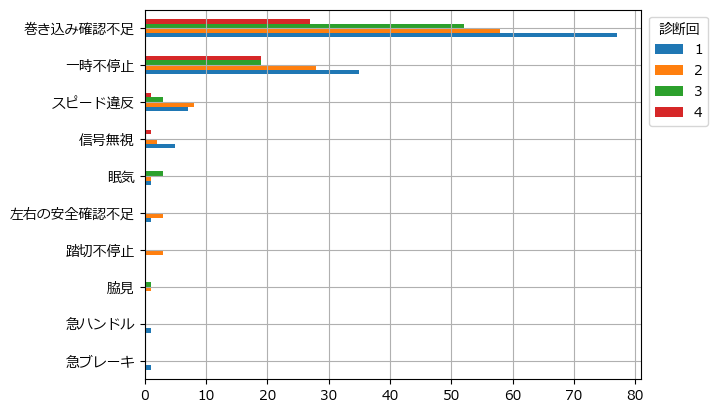

<Figure size 1037.4x659.055 with 0 Axes>

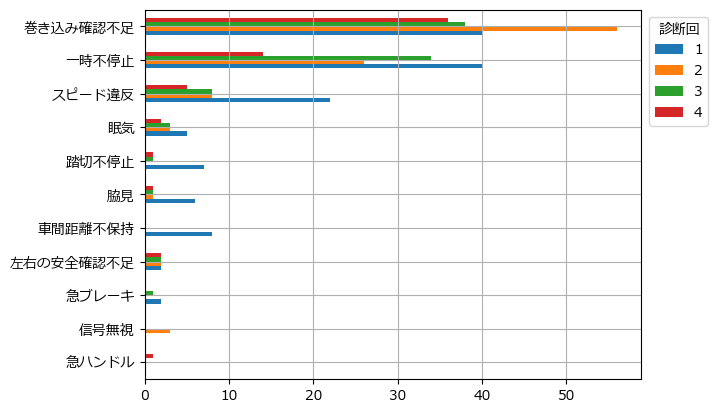

<Figure size 1037.4x659.055 with 0 Axes>

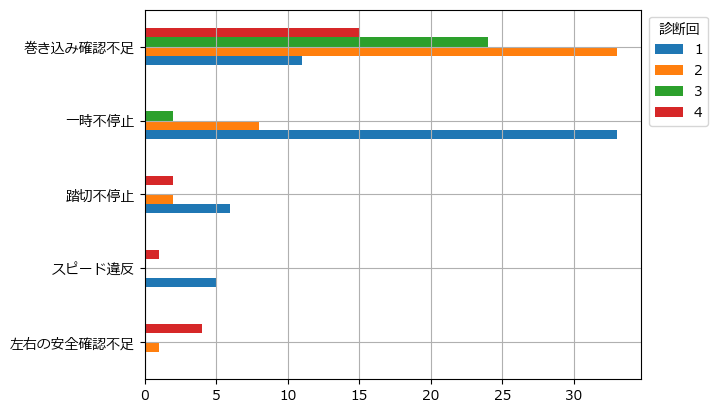

<Figure size 1037.4x659.055 with 0 Axes>

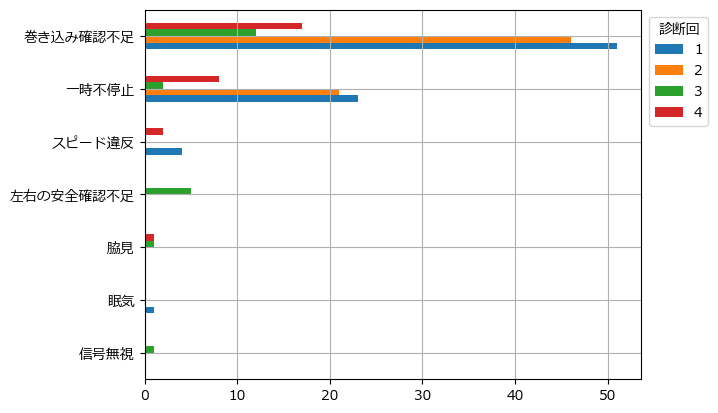

In [1]:
import sawakai_tool as stool

stool.make_sawakai_pdf()

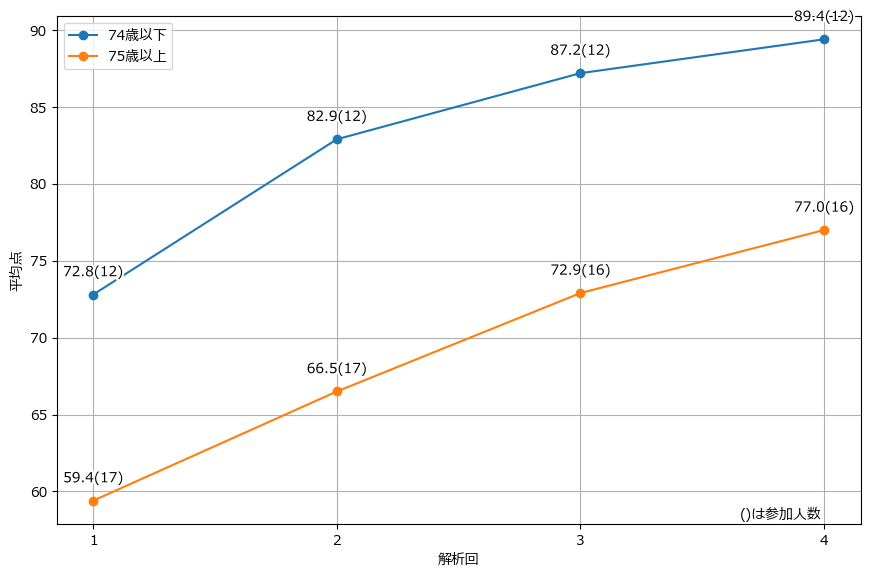

In [85]:
import matplotlib.patheffects as patheffects
from matplotlib.ticker import MaxNLocator

with open('./sql/score_sql.txt','r',encoding='utf-8') as f:
    sql = f.read()

df = stool.send_sql_to_snowflake(sql.replace('[GROUP_NUMBER]',str(3)))
plt.rcParams['font.family'] = 'Meiryo'
fig = plt.figure(figsize=((26.35/2.54), (16.74/2.54)))
ax = fig.add_subplot()
df['解析回']= df['解析回'].astype('int')
df['平均点']= df['平均点'].astype('float')
cross_df = pd.crosstab(df['解析回'],df['年齢グループ'],values=df['平均点'],aggfunc='sum')
for idx, val in df.iterrows():
        ax.text(
        df['解析回'][idx], df['平均点'][idx]+1, f"{df['平均点'][idx]:,}({df['参加人数'][idx]})", ha='center', va='bottom',
        path_effects=[patheffects.withStroke(linewidth=3, foreground='white', capstyle="round")]
    )

for col in cross_df.columns:
     ax.plot(cross_df.index.to_list(),cross_df[col],marker="o")
ax.text(0.85, 0.01, "()は参加人数", transform=ax.transAxes)
ax.set_xlabel('解析回')
ax.set_ylabel('平均点')
ax.legend(cross_df.columns)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.show()

In [63]:
cross_df.index.to_list()

Index([1, 2, 3, 4], dtype='int64', name='解析回')

np.int8(1)

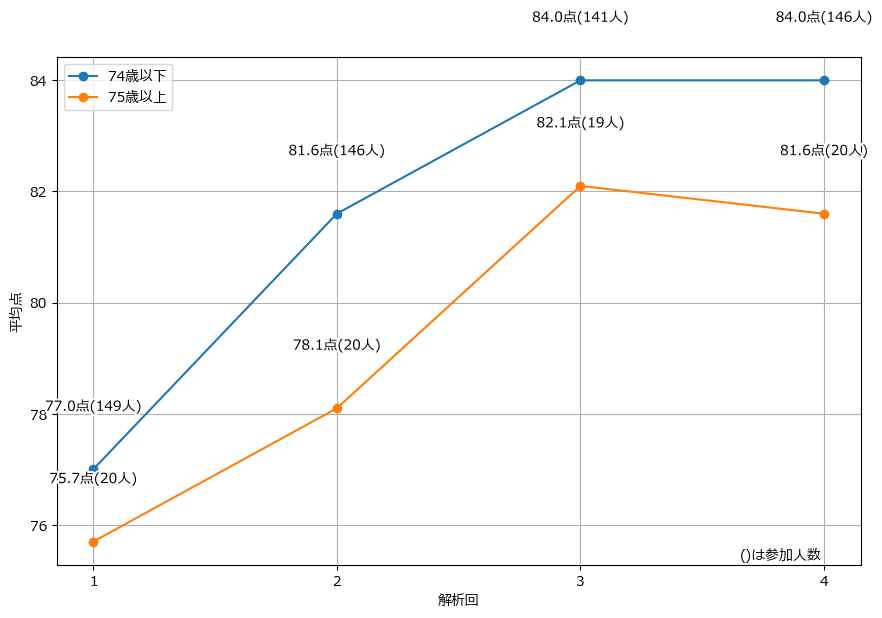

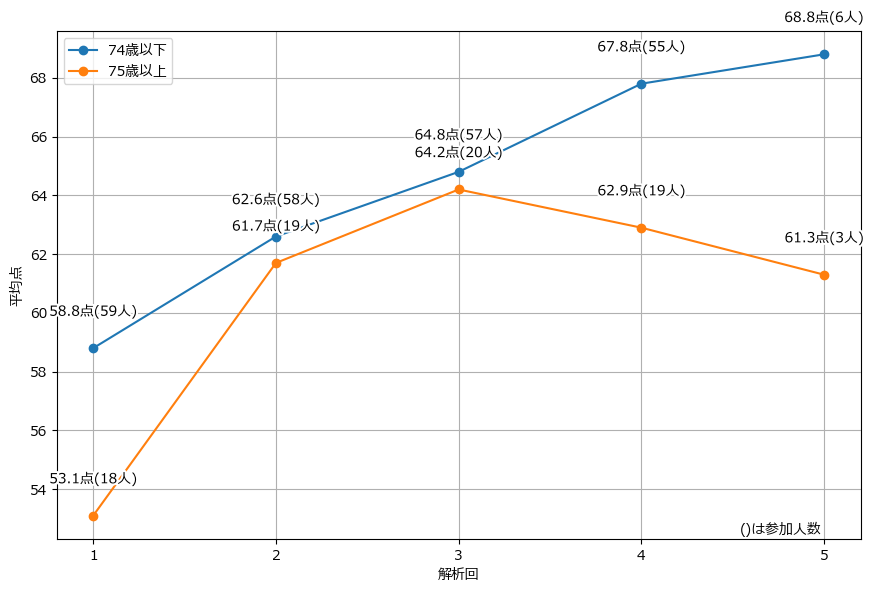

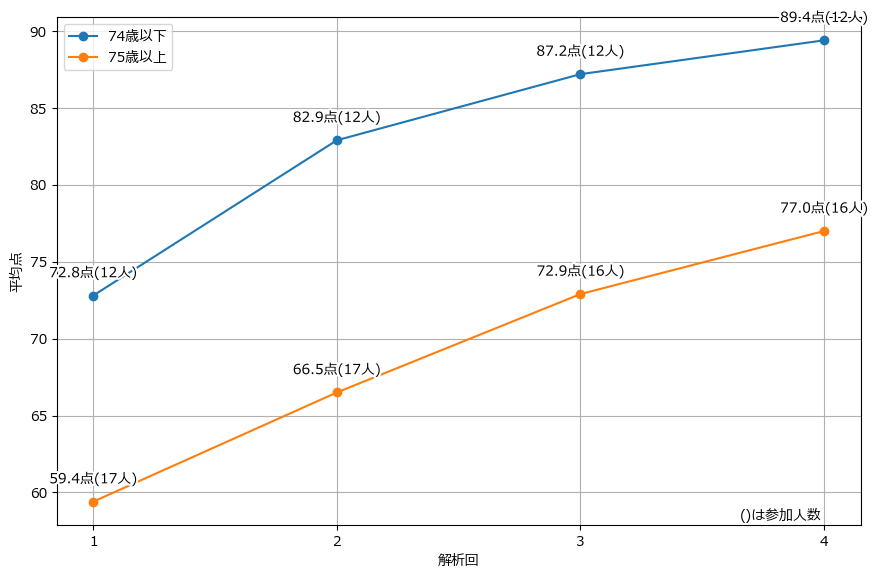

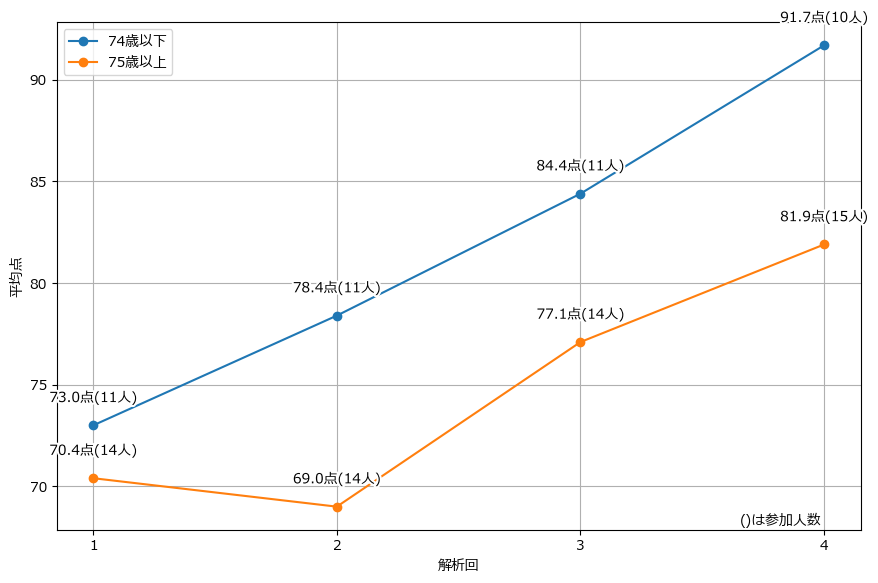

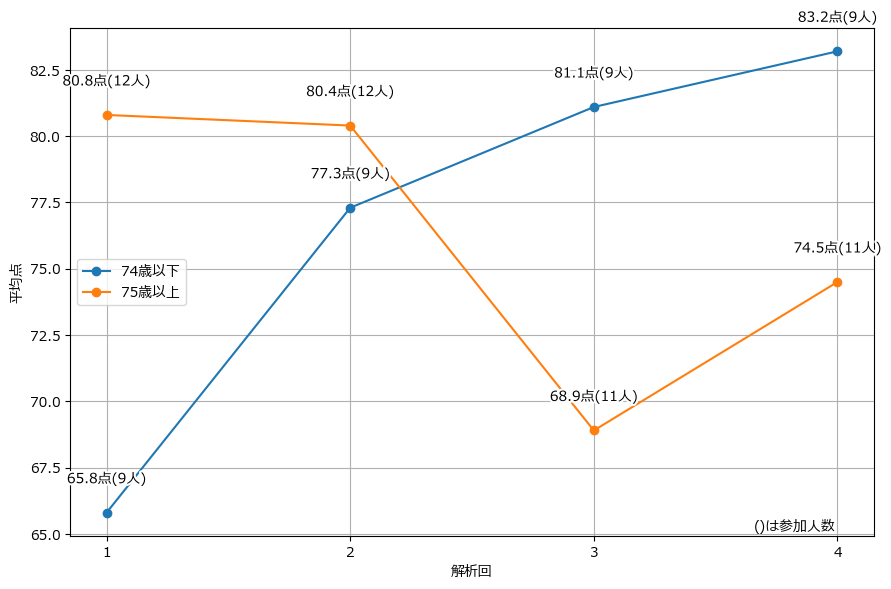

In [3]:
import sawakai_tool as stool

for i in [1,2,3,40,41]:
    df = stool.make_agegroup_graph(i)

In [14]:
df['平均点']= df['平均点'].astype('float')

In [6]:
glob(p)

['./outputs/documents\\豊田グループ２_個人_5回目.pptx',
 './outputs/documents\\豊田グループ３_井上友睦会_4回目.pptx',
 './outputs/documents\\豊田グループ３_京峰会_4回目.pptx',
 './outputs/documents\\豊田グループ３_個人_4回目.pptx',
 './outputs/documents\\豊田グループ３_御船寿楽会_4回目.pptx',
 './outputs/documents\\豊田グループ３_東山ひまわり会_4回目.pptx',
 './outputs/documents\\豊田グループ３_豊栄第一長寿会_4回目.pptx']

In [33]:
import datetime
import os
from glob import glob
import pandas as pd

folder = './outputs/documents/*'
files = glob(folder)

datalist = []

for f in files:
    filename = f.split('\\')[-1]
    t = os.path.getmtime(f)
    d = datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S')
    datalist.append([filename,d])
    #df = pd.concat(df,pd.DataFrame(data=[f.split('\\')[-1],d],columns=['ファイル名','更新日時']))

df = pd.DataFrame(data=datalist,columns=['ファイル名','更新日時'])
df


,ファイル名,更新日時
0,豊田グループ２_個人_5回目.pptx,2024-08-20 21:16:51
1,豊田グループ３_井上友睦会_4回目.pptx,2024-08-22 18:12:25
2,豊田グループ３_京峰会_4回目.pptx,2024-08-22 18:12:22
3,豊田グループ３_個人_4回目.pptx,2024-08-22 18:12:16
4,豊田グループ３_御船寿楽会_4回目.pptx,2024-08-22 18:12:19
5,豊田グループ３_東山ひまわり会_4回目.pptx,2024-08-22 18:12:20
6,豊田グループ３_豊栄第一長寿会_4回目.pptx,2024-08-22 18:12:12


In [36]:
import zipfile
import os
choices = ['豊田グループ３_井上友睦会_4回目.pptx']

if not os.path.exists(f'./outputs/zip'):
      os.mkdir(f'./outputs/zip')

with zipfile.ZipFile('./outputs/zip/download_pptx.zip', 'w') as zipf:
    for pptx_file in choices:
            zipf.write(f'./outputs/documents/{pptx_file}')